In [89]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output
from typing import Callable

from mri_data import file_manager as fm
from mri_data import utils

## Load Data

In [91]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/gradient_analysis")
dataproc_root = Path("/mnt/h/srs-9/thalamus_project/data")
subject_sessions = pd.read_csv("/home/srs-9/Projects/ms_mri/data/subject-sessions.csv", index_col="sub")['ses']

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid")
df = df.join([choroid_volumes, tiv, sdmt['SDMT']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
df['thalamus_curt'] = np.sqrt(df['thalamus']**3)
df['cortical_thickness_inv'] = 1 / df['cortical_thickness']
df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

In [73]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ignore_structs1 = ["THALAMUS_1", "Amy_34", "GP_33", "Cla_28", "Acc_26", "Hb_13", "MTT_14"]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)['index']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_SDT.csv", index_col="subid")
dists_newcols = {str(i): f"{hips_thomas_ref[i]}_dist" for i in hips_thomas_ref.index}
choroid_dists = choroid_dists.rename(columns=dists_newcols)
choroid_dists_z = choroid_dists.apply(stats.zscore, nan_policy="omit")
ventricle_dists = pd.read_csv(
    data_dir / "centroid-ventricle_SDT.csv", index_col="subid"
)

mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni-centroid-choroid_SDT2.csv")

Pul_8


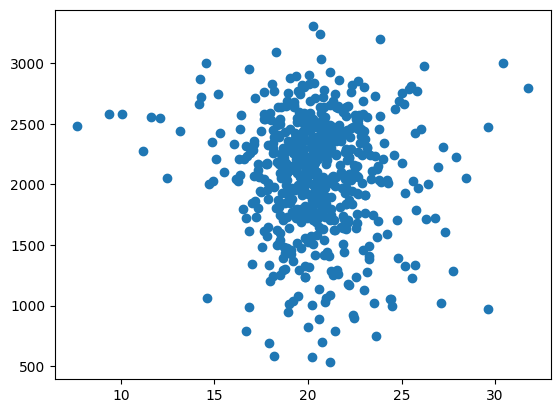

In [107]:
model_data = df.join([df_thomas, choroid_dists])
model_data = model_data.loc[~model_data.index.isin([1011]), :]
ind = 8
dist_name = f"{hips_thomas_ref[ind]}_dist"
struct = hips_thomas_ref[ind]
print(struct)
plt.scatter(model_data[dist_name], model_data[struct])

In [106]:
model_data.sort_values(by="Pul_8_dist")[choroid_dists.columns]

,AV_2_dist,VA_4_dist,VLa_5_dist,VLP_6_dist,VPL_7_dist,Pul_8_dist,LGN_9_dist,MGN_10_dist,CM_11_dist,MD_Pf_12_dist,Hb_13_dist,MTT_14_dist,Acc_26_dist,Cau_27_dist,Cla_28_dist,GPe_29_dist,GPi_30_dist,Put_31_dist,RN_32_dist
subid,,,,,,,,,,,,,,,,,,,
2021,31.068831,31.023934,25.904334,21.434197,13.308179,7.681561,20.996739,17.062369,17.537494,20.882586,19.336411,34.341098,52.313848,43.998270,45.343293,36.896778,34.224295,39.861209,29.184167
1267,35.496440,35.225287,29.722296,25.558856,16.695979,9.370802,24.532887,17.751647,19.292044,22.416332,18.423869,36.152331,58.384649,51.299097,52.252689,42.631012,39.501381,46.404346,29.431954
1477,26.402239,28.536103,24.444807,18.574410,13.275372,10.083242,25.850045,19.552585,17.107788,17.993560,18.669202,32.840351,52.772773,42.512913,46.879048,36.470242,34.570958,40.559010,29.989264
2001,27.815200,28.701764,25.687008,20.132937,16.223820,11.198708,25.602278,18.758907,16.018596,15.771339,14.228181,29.819238,53.049016,43.907741,49.172222,38.375681,36.429051,42.983207,26.469768
1364,31.343578,34.040599,29.875889,24.710304,18.525136,11.608318,25.887596,19.253271,19.593377,21.016838,18.195327,35.705125,56.720618,50.081460,53.190906,42.230788,39.616385,46.549528,29.968650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,16.425159,22.283878,26.615130,23.844969,32.074008,31.773843,44.094623,34.335823,25.002564,17.527839,21.345345,25.114760,40.626305,33.803083,52.181034,36.006878,35.056401,43.645553,28.786253
1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
import pyperclip

pioneer_bids = Path("/mnt/h/3Tpioneer_bids")
inf_root = Path("/mnt/h/srs-9/3Tpioneer_bids_predictions")
sub = 1364
ses = subject_sessions[sub]

subject_root1 = dataproc_root / f"sub{sub}-{ses}"
subject_root2 = pioneer_bids / f"sub-ms{sub}" / f"ses-{ses}"
subject_root3 = inf_root / f"sub-ms{sub}" / f"ses-{ses}"
image_names1 = ["t1.nii.gz"]
images = [subject_root1 / im for im in image_names1]
label_names1 = ["choroid.nii.gz"]
labels = [subject_root1 / lab for lab in label_names1]

image_names2 = ["flair.nii.gz"]
images = images + [subject_root2 / im for im in image_names2]
label_names3 = ["t1_choroid_pineal_pituitary_T1-1_pred.nii.gz"]
labels = labels + [subject_root3 / im for im in label_names3]

images = [im for im in images if im.exists()]
labels = [im for im in labels if im.exists()]

cmd = utils.open_itksnap_workspace_cmd(images, labels, win=True)
pyperclip.copy(cmd)

In [86]:
subject_sessions

,ses
sub,
1001,20170215
1002,20200521
1003,20170329
1004,20190906
1005,20200708
...,...
3020,20170307
3021,20161117
3023,20170727


In [27]:
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
choroid_dists = pd.read_csv(data_dir / "centroid-choroid_SDT.csv", index_col="subid")
mni_dist = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni-centroid-choroid_SDT.csv", index_col="struct")

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']

mni_dist['struct_name'] = hips_thomas_ref

mean_dists = choroid_dists.mean()

In [20]:
for i in enumerate(hips_thomas_ref):
    print(i)

(0, 'THALAMUS_1')
(1, 'AV_2')
(2, 'VA_4')
(3, 'VLa_5')
(4, 'VLP_6')
(5, 'VPL_7')
(6, 'Pul_8')
(7, 'LGN_9')
(8, 'MGN_10')
(9, 'CM_11')
(10, 'MD_Pf_12')
(11, 'Hb_13')
(12, 'MTT_14')
(13, 'Acc_26')
(14, 'Cau_27')
(15, 'Cla_28')
(16, 'GPe_29')
(17, 'GPi_30')
(18, 'Put_31')
(19, 'RN_32')
(20, 'GP_33')
(21, 'Amy_34')
